![CH5-ADS.png](.\Media\CH5-ADS.png)
# <span style="color:#cc5500;">Interpreting DBCC CHECKDB Output</span>

The first signs of Corruption

- Users report connections being broken, possibly 823 or 824 errors
- Backup jobs start failing
    - Error 3043 –backup detected checksum errors
- SQL Agent alerts start firing
- Maintenance jobs start failing
- Errors in the SQL Server error log

All these are signs that you’ve got corruption somewhere

Running DBCC CHECKDB  

- Use the following command with only these options:
-  DBCC CHECKDB (yourdb) WITH NO\_INFOMSGS
    - Add ALL\_ERRORMSGSwhen using SQL Server 2008 RTM or before
- It is a good idea to know in advance through your previous checks, to know how long it usually takes to run for a database
    - Allows you to report to management how long before results are known when a disaster occurs
    - Longer run time usually indicates some corruption has been found
- Wait for the command to complete
    - It’s the only way to know what corruptions you have
    - Don’t jump the gun and assume you need to restore
- Look through the output for anything significant

## <span style="color:#cc5500;">Where Does DBCC CHECKDB Output Go?</span>

- As long as the command is not interrupted:
    - Completion message is written to the SQL Server error log
    - Completion message is written to the Windows Application event log
- Regular output only goes to the connection running the command
- If corruptions are found:
    - Severity 16 messages are printed as part of the output but do not cause TRY/CATCH blocks to go into the CATCH block
    - SSMS (SQL Server Management Studio) will report that the query failed, even though the command completed successfully
    - SSMS will only report the first 1,000 error messages


# <span style="color:#cc5500;">Corruption Demo</span>

## <span style="color:#da2433;">DISCLAIMER: This Demo purposefully corrupts a test database!!&nbsp; The information in this section should not be used on a production SQL Server system. Any problem, corruption, damage, or loss you cause by using the information presented here is entirely your own responsibility. Use at your own risk.&nbsp; If DBCC WRITEPAGE is run against the master database, it can cause your SQL Server to shut down and not start again until master is repair.&nbsp; It is highly recommended that you perform this on a test system.</span>

Use on a Test User Database on a Test Server, and not on a System database.

This setup script uses the undocumented DBCC WRITEPAGE command against a test database to cause corruption and the undocumented DBCC IND command to find pages to corrupt.  These two DBCC's were created by the Microsoft Product Group in order to create DBCC CHECKDB that is used in the repair of a database.

### <span style="color:rgb(0, 204, 153);">Run the Code block below</span>

1. Click the run icon below
2. If ADS prompts you for a connection, enter the correct SQL Server and authentication account
3. View the results of the query by scrolling down to the results set

In [ ]:
-- Cleanup from the previous notebook demo
-- Create 2 test databases
USE [master];
GO

IF DATABASEPROPERTYEX (N'Company', N'Version') > 0
BEGIN
	ALTER DATABASE [Company] SET SINGLE_USER
		WITH ROLLBACK IMMEDIATE;
	DROP DATABASE [Company];
END
GO

-- Create a new database
CREATE DATABASE [Company] ON PRIMARY (
    NAME = N'Company',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company.mdf')  --modify path for your environment
LOG ON (
    NAME = N'Company_log',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company_log.ldf'); --modify path for your environment
GO

IF DATABASEPROPERTYEX (N'Company2', N'Version') > 0
BEGIN
	ALTER DATABASE [Company2] SET SINGLE_USER
		WITH ROLLBACK IMMEDIATE;
	DROP DATABASE [Company2];
END
GO

-- Create a new database
CREATE DATABASE [Company2] ON PRIMARY (
    NAME = N'Company2',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company2.mdf')  --modify path for your environment
LOG ON (
    NAME = N'Company2_log',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company2_log.ldf'); --modify path for your environment
GO

In [ ]:
-- Create a table in each test database and add some records 
USE [Company];
GO

CREATE TABLE [RandomData] (
	[c1]  INT IDENTITY,
	[c2]  CHAR (8000) DEFAULT 'a');
GO

INSERT INTO [RandomData] DEFAULT VALUES;
GO 10

USE [Company2];
GO

CREATE TABLE [RandomData] (
	[c1]  INT IDENTITY,
	[c2]  CHAR (8000) DEFAULT 'a');
GO

INSERT INTO [RandomData] DEFAULT VALUES;
GO 10

In [ ]:
-- List the pages in the table in the Company2 database
DBCC IND (N'Company2', N'RandomData', -1);
GO


Pick a data page to corrupt.

Your query will return different values, but in my case, I'm going to choose  PageFID 1 and PagePID 364

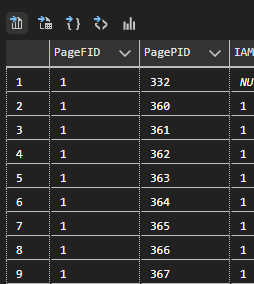

In [ ]:
-- Pick a page in Company2 to corrupt
-- Just replace the two values for B, B  the remaining values in place   (N'Company2', B, B, 0, 2, 0x0000, 1);
ALTER DATABASE [Company2] SET SINGLE_USER;
GO
DBCC WRITEPAGE (N'Company2', 1, 364, 0, 2, 0x0000, 1);
GO
ALTER DATABASE [Company2] SET MULTI_USER;
GO


In [ ]:
-- Do some cleanup before the demo
-- Clean the error log and suspect_pages
DELETE FROM [msdb].[dbo].[suspect_pages];
EXEC sp_cycle_errorlog;
GO

Now that we have picked a page to Corrupt, cleared out the msdb suspect\_pages table, and cycled the error log, We are now ready for the demo

### <span style="color:rgb(0, 204, 153);">Run the Code block below</span>

1. Click the run icon below
2. If ADS prompts you for a connection, enter the correct SQL Server and authentication account
3. View the results of the query by scrolling down to the results set

In [ ]:
-- Run CHECKDB on the good database and view the results
DBCC CHECKDB (N'Company') WITH NO_INFOMSGS;
GO

In [ ]:
-- No check the Corrupt database and view the results of the two Level 16 errors and that the page you corrupted cannot be processed
-- Review the two consistency errors.  It identifies the impacted table and then gives you a summary of the database
-- Then it tells you, that if you want to fix this, repair_allow_data_loss is the minimum repair level
DBCC CHECKDB (N'Company2') WITH NO_INFOMSGS;
GO

-- You can also review the SQL Error Log and in the Error Log, you can find the location of the text file created by the Stack Dump and review the contents of the dump file

## <span style="color:#cc5500;">Interpreting the Output</span>

- There are over 100 errors that DBCC CHECKDB can output, some with over 200 message states
    
    - Effectively there are roughly a thousand different corruption conditions that can be reported
- Figuring out what one corruption means isn’t too bad
    
    - We have some of them published and they can be found by searching Bing or Google for the Error Message
- Figuring out multiple corruptions can become very hard and usually isn’t worth the time
    
- There are some tips and tricks you can use to determine the course of action to take and we will cover those in this notebook
    
- Did DBCC CHECKDB fail?
    
    - If it stops before completing successfully, something bad has happened that is preventing it from running correctly
    - <span style="color:#cc5500;">This means there is no choice but to restore from a backup or try exporting the data, as DBCC CHECKDB cannot be forced to run (and hence repair)</span>
- Examples of fatal (to DBCC CHECKDB) errors:
    
    - 7984 –7988: corruption in critical system tables
    - 8967: invalid states within DBCC CHECKDB itself
    - 8930: corrupt metadata such that DBCC CHECKDB could not run
- The SQL Server error log message will list an error state

## <span style="color:#cc5500;">Here's more to help you</span>

- Are the corruptions only in nonclustered indexes?
    
    - <span style="background-color: rgba(127, 127, 127, 0.1);">If recommended repair level is REPAIR_REBUILD, then yes</span>
    - Otherwise, check all the index IDs in the errors and if they’re all greater than 1, then yes
    - If yes, you don’t need to restore or run repair, as we’ll see in Module 8
- Was there an un-repairable error found?
    - Examples:
        - 2570 error: invalid data for the column type (data purity error)
        - 8992 error: CHECKCATALOG(metadata mismatch) error
        - 8909, 8938, 8939 (page header corruption) errors where type is ‘PFS’
        - None of these can be automatically repaired so your options are to restore or to attempt manual repairs

- Everything else not mentioned I classify as “general corruptions”
    - Your options are to restore or repair or export to a new database
- The more corruptions there are, the harder it is to figure out what’s actually broken
    - It also depends on what kind of page is corrupt
- For example, for a data page in the leaf level of a clustered index:
    - There may just be one error about one row on the page
    - And there may also be a matching error about each nonclustered index
    - And there may also be a matching error about each off-row LOB value in the row
- There may be an error that the entire page cannot be processed
    - And there will also be errors about broken links to other pages
    - And there may also be errors about nonclustered indexes

# <span style="color:#cc5500;">Fatal Corruption Demo: Database Killers</span>

## <span style="color:#da2433;">DISCLAIMER: This Demo purposefully corrupts a test database!!&nbsp; The information in this section should not be used on a production SQL Server system. Any problem, corruption, damage, or loss you cause by using the information presented here is entirely your own responsibility. Use at your own risk.&nbsp; If DBCC WRITEPAGE is run against the master database, it can cause your SQL Server to shut down and not start again until master is repair.&nbsp; It is highly recommended that you perform this on a test system.</span>

Use on a Test User Database on a Test Server, and not on a System database.

This setup script uses the undocumented DBCC WRITEPAGE command against a test database to cause corruption and the undocumented DBCC IND command to find pages to corrupt.  These two DBCC's were created by the Microsoft Product Group in order to create DBCC CHECKDB that is used in the repair of a database.

### <span style="color:rgb(0, 204, 153);">Run the Code block below</span>

1. Click the run icon below
2. If ADS prompts you for a connection, enter the correct SQL Server and authentication account
3. View the results of the query by scrolling down to the results set

In [ ]:
-- Setup script for Fatal Errors demo.

-- Remove any old databases and then re-create them fresh
USE [master];
GO

IF DATABASEPROPERTYEX (N'FatalCorruption1', N'Version') > 0
BEGIN
	ALTER DATABASE [FatalCorruption1] SET SINGLE_USER
		WITH ROLLBACK IMMEDIATE;
	DROP DATABASE [FatalCorruption1];
END

IF DATABASEPROPERTYEX (N'FatalCorruption2', N'Version') > 0
BEGIN
	ALTER DATABASE [FatalCorruption2] SET SINGLE_USER
		WITH ROLLBACK IMMEDIATE;
	DROP DATABASE [FatalCorruption2];
END
GO

IF DATABASEPROPERTYEX (N'FatalCorruption3', N'Version') > 0
BEGIN
	ALTER DATABASE [FatalCorruption3] SET SINGLE_USER
		WITH ROLLBACK IMMEDIATE;
	DROP DATABASE [FatalCorruption3];
END
GO

-- Create new databases
CREATE DATABASE [FatalCorruption1] ON PRIMARY (
    NAME = N'FatalCorruption1',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\FatalCorruption1.mdf')  -- Modify for your path
LOG ON (
    NAME = N'FatalCorruption1_log',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\FatalCorruption1_log.ldf');  -- Modify for your path

CREATE DATABASE [FatalCorruption2] ON PRIMARY (
    NAME = N'FatalCorruption2',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\FatalCorruption2.mdf')  -- Modify for your path
LOG ON (
    NAME = N'FatalCorruption2_log',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\FatalCorruption2_log.ldf');  -- Modify for your path

CREATE DATABASE [FatalCorruption3] ON PRIMARY (
    NAME = N'FatalCorruption3',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\FatalCorruption3.mdf')  -- Modify for your path
LOG ON (
    NAME = N'FatalCorruption3_log',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\FatalCorruption3_log.ldf');  -- Modify for your path
GO


In [ ]:
-- Disable page protection to allow the demo to work
ALTER DATABASE [FatalCorruption1] SET PAGE_VERIFY NONE;
ALTER DATABASE [FatalCorruption2] SET PAGE_VERIFY NONE;
ALTER DATABASE [FatalCorruption3] SET PAGE_VERIFY NONE;
GO

In [ ]:
-- Prepare databases for using DBCC WRITEPAGE
ALTER DATABASE [FatalCorruption1] SET SINGLE_USER;
ALTER DATABASE [FatalCorruption2] SET SINGLE_USER;
ALTER DATABASE [FatalCorruption3] SET SINGLE_USER;
GO

Warning!

Below, we will corrupt all three test databases in such a way that the create Fatal Errors

In [ ]:
-- Corrupt this databases' fileheader page which is page zero of every file
DBCC WRITEPAGE (N'FatalCorruption1', 1, 0, 0, 4, 0x00000000, 1);
GO

-- Corrupt this databases' boot page
DBCC WRITEPAGE (N'FatalCorruption2', 1, 9, 0, 4, 0x00000000, 1);
GO

-- Corrupt this databases' some of the critical system table metadata
DBCC WRITEPAGE (N'FatalCorruption3', 1, 20, 0, 4, 0x00000000, 1);
GO
DBCC WRITEPAGE (N'FatalCorruption3', 1, 17, 0, 4, 0x00000000, 1);
GO


In [ ]:
-- Return databases to usable state.  Because of the corruption we created (you'll see an error when running this).  Ignore the error
ALTER DATABASE [FatalCorruption1] SET MULTI_USER;
ALTER DATABASE [FatalCorruption2] SET MULTI_USER;
ALTER DATABASE [FatalCorruption3] SET MULTI_USER;
GO

In [ ]:
-- Clean the error log and suspect_pages
DELETE FROM [msdb].[dbo].[suspect_pages];
EXEC sp_cycle_errorlog;
GO

It is now time to run DBCC CHECKDB to see the results of the damage we created.

In [ ]:
-- Corrupt fileheader page
DBCC CHECKDB (N'FatalCorruption1') WITH NO_INFOMSGS;
GO

-- View the results of the Errors.  You see that this is a fatal error, CHECKDB can't complete.  That also means that you will not be able to run REPAIR 
-- This now limits your RECOVERY options to RESTORE from backup or try to export data out to a new database

In [ ]:
-- Corrupt boot page
DBCC CHECKDB (N'FatalCorruption2') WITH NO_INFOMSGS;
GO

-- View the results of the Errors.  You see that this is a fatal error, CHECKDB can't complete.  That also means that you will not be able to run REPAIR 
-- This now limits your RECOVERY options to RESTORE from backup or try to export data out to a new database

In [ ]:
-- Corrupt metadata
-- You may see different messages depending on which
-- version of SQL Server you are using
DBCC CHECKDB (N'FatalCorruption3') WITH NO_INFOMSGS;
GO

-- View the results of the Errors.  You see that this is a fatal error, CHECKDB can't complete.  That also means that you will not be able to run REPAIR 
-- This now limits your RECOVERY options to RESTORE from backup or try to export data out to a new database

## <span style="color:#cc5500;">Restore vs. Repair</span>

Although many people say that repair is a last resort, it could be that restoring from a backup would take much longer than a repai.  If downtime is more important than data loss, repair may be better  There is always the option to try exporting data from the damaged database.

Multiple decision points that can short-circuit the decision process

- Do you still have a database?
    - No –you must restore from a backup
- Do you have working backups?
    - No –you must use repair, or restore a damaged backup (advanced), or export data to a new database
- Is the transaction log damaged?
    - Yes –you must restore, or run emergency mode repair (advanced), or export data to a new database
- Did DBCC CHECKDB fail?
    - Yes –you must restore or export, as you cannot run repair
- Is it just nonclustered indexes that are damaged?
    - Yes –neither restore or repair, manually rebuild them (Module 8)
- Are there any un-repairable errors?
    - Yes –you must restore or export, or potentially manually repair them
    - Some manual repairs are trivial, but most are (usually very) advanced
- If you’re still able to make a repair vs. restore choice:
    - Consider your down time and data loss Service Level Agreements
    - Use whichever option you can which allows you to limit down time and data loss while still staying within the SLAs

## <span style="color:#cc5500;">Exporting data to a new database</span>

- If repair or restore are not possible, you must export as much data as possible into a new database
    - Steps to take:
        - Create the new database with the same tables and indexes
        - And stored procedures, functions, etc.
        - SELECT as much data as possible from all tables into the new database

Corruptions may complicate this and call for advanced methods